<a href="https://colab.research.google.com/github/Anshu00027/SAE-for-PINNs/blob/main/SAE-for-Taylor-Green-Vortex-PINNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# We are loading the data collected from a trained PINNs model with architecture [3, 25, 25, 3], solving Taylor Vortex Green problem, considering the activations of the last hidden layer (the second hidden layer) which contains 25 neurons
# These activations are collected for all training points(3475). so the shape should be (3475,25)
activations_array = np.load("/content/drive/MyDrive/SAE_project/last_hidden_activations.npy")
print(activations_array.shape)

(3475, 25)


We use the above activation data as inputs to train a Sparse Autoencoder. The hidden_tensor contains these activations, and we organize them into a dataset where each input equals its target output. To improve training efficiency, we divide the data into mini-batches of 139 samples, allowing the model to iteratively update weights over multiple batches per epoch.

The SparseAutoencoder class defines an encoder-decoder architecture with a hidden layer of size h_dims. A sigmoid activation maps the input to the latent space, while a Tanh activation reconstructs the input from the latent representation. The sparsity constraint is controlled by sparsity_lambda and sparsity_target, which encourage most neurons to remain inactive for a given input, promoting a compact and informative latent representation.

The loss function combines the mean squared error between the output and its reconstruction, which ensures that the autoencoder accurately reconstructs the original activations, with a KL-divergence-based sparsity penalty.
The KL-divergence-based sparsity penalty is applied to the encoded activations to encourage most hidden neurons to remain inactive for each input. It measures the difference between the desired average activation (sparsity_target) and the actual average activation of each hidden neuron

Xavier initialization is used to initialize the weights, ensuring a stable start for training.

In [4]:
# Use all activations from last hidden layer
hidden_tensor = torch.tensor(activations_array, dtype=torch.float32)

# Dataset (input,output)
dataset = TensorDataset(hidden_tensor, hidden_tensor)
dataloader = DataLoader(dataset, batch_size=139, shuffle=True)
# Here, we use mini-batching to improve training efficiency. Instead of processing all 3,475 activation samples at once in a single epoch, the data is divided into smaller batches of 139 samples each. The model iteratively trains on these mini-batches, completing one full pass (epoch) after all batches are processed.


# Sparse Autoencoder
class SparseAutoencoder(nn.Module):
    def __init__(self, in_dims, h_dims, sparsity_lambda, sparsity_target,xavier_norm_init=True):    # These parameters control the sparsity constraint in the sparse autoencoder.
        super().__init__()                                                               # The sparsity_target defines the desired average activation level of the hidden neurons encouraging most neurons to remain inactive for a given input.
                                                                                         # The sparsity_lambda determines how strongly this sparsity penalty influences the total loss during training.
        self.xavier_norm_init = xavier_norm_init
        self.encoder = nn.Sequential(                   # The encoder consists of a fully connected layer that maps the input features to a hidden space (h_dims),by a Sigmoid activation function.
            nn.Linear(in_dims, h_dims),
            nn.Sigmoid() )

        if self.xavier_norm_init:
            nn.init.xavier_uniform_(self.encoder[0].weight)
            nn.init.constant_(self.encoder[0].bias, 0)

        self.decoder = nn.Sequential(                 # The decoder reconstructs the original input from the compressed hidden representation.
            nn.Linear(h_dims, in_dims),
            nn.Tanh())

        if self.xavier_norm_init:
            nn.init.xavier_uniform_(self.decoder[0].weight)
            nn.init.constant_(self.decoder[0].bias, 0)

        self.sparsity_lambda = sparsity_lambda
        self.sparsity_target = sparsity_target

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded
                                                                              # This function computes the KL sparsity penalty, which encourages the hidden layer activations to remain close to a target sparsity level. This sparsity penalty is applied on the encoded activations
    def sparsity_penalty(self, encoded):
        rho_hat = torch.mean(encoded, dim=0)
        rho = self.sparsity_target
        epsilon = 1e-8
        rho_hat = torch.clamp(rho_hat, min=epsilon, max=1-epsilon)
        kl_div = rho * torch.log(rho / rho_hat) + (1-rho) * torch.log((1-rho)/(1-rho_hat))
        return self.sparsity_lambda * torch.sum(kl_div)

    def loss_function(self, decoded, x, encoded):
        mse_loss = nn.functional.mse_loss(decoded, x)
        return mse_loss + self.sparsity_penalty(encoded)


In [12]:
# Initialize and train
in_dims = hidden_tensor.shape[1]
h_dims = 80
sparsity_lambda=1e-4
sparsity_target=0.05
sae = SparseAutoencoder(in_dims, h_dims,sparsity_lambda, sparsity_target)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sae.to(device)
optimizer = torch.optim.Adam(sae.parameters(), lr=1e-3)

# Training
n_epochs = 400
last_batch_encoded = None

for epoch in range(n_epochs):
    total_loss = 0
    for batch_x, _ in dataloader:
        batch_x = batch_x.to(device)
        optimizer.zero_grad()
        encoded, decoded = sae(batch_x)
        loss = sae.loss_function(decoded, batch_x, encoded)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        # Keep last batch activations
        last_batch_encoded = encoded.detach().cpu().numpy()
    if epoch % 50 == 0:
        print(f"Epoch {epoch+1}/{n_epochs} - Loss: {total_loss/len(dataloader):.6f}")

# After training
np.save("last_batch_encoded.npy", last_batch_encoded)
print("Saved last mini-batch encoded activations:", last_batch_encoded.shape)


# Save the encoded representation
with torch.no_grad():
    encoded, _ = sae(hidden_tensor.to(device))

encoded = encoded.cpu().numpy()
np.save("train_last_hidden_encoded.npy", encoded)
print("Saved SAE encoded features shape:", encoded.shape)

Epoch 1/400 - Loss: 2.919002
Epoch 51/400 - Loss: 1.958141
Epoch 101/400 - Loss: 1.951652
Epoch 151/400 - Loss: 1.949778
Epoch 201/400 - Loss: 1.947246
Epoch 251/400 - Loss: 1.946317
Epoch 301/400 - Loss: 1.945713
Epoch 351/400 - Loss: 1.945360
Saved last mini-batch encoded activations: (139, 80)
Saved SAE encoded features shape: (3475, 80)


now we are printing the activation values of neurons for each sample in the mini-batch.
    
Each row corresponds to the activation of neuron for a single sample from the mini-batch.

In [31]:
# Convert hidden activations to a DataFrame
activations = np.array(last_batch_encoded)  # (batch_size, num_neurons)
df = pd.DataFrame(activations, columns=[f"Neuron {i+1}" for i in range(activations.shape[1])])
# Show first 10 samples (rows) and first 10 neurons (columns) for readability
df_subset = df.iloc[:10, :10]

# Display in Colab
df_subset


,Neuron 1,Neuron 2,Neuron 3,Neuron 4,Neuron 5,Neuron 6,Neuron 7,Neuron 8,Neuron 9,Neuron 10
0,0.0683,0.0629,0.0250,0.0797,0.5176,0.9260,0.0748,0.0280,0.0623,0.2499
1,0.0357,0.0339,0.0147,0.9192,0.4462,0.3948,0.0551,0.0790,0.0782,0.2661
2,0.1188,0.0657,0.0060,0.0776,0.5670,0.0436,0.1500,0.0666,0.0666,0.6613
3,0.0810,0.1337,0.1938,0.0166,0.3594,0.9992,0.0499,0.0093,0.0676,0.0776
4,0.0120,0.0155,0.0184,0.9981,0.3999,0.4593,0.0211,0.1069,0.0677,0.1743
5,0.1383,0.0648,0.0015,0.0875,0.6538,0.0003,0.2137,0.1315,0.0533,0.9297
6,0.0094,0.0303,0.0026,0.0577,0.7958,0.0232,0.0433,0.0306,0.0097,0.6490
7,0.0929,0.1353,0.1747,0.0194,0.3331,0.9980,0.0569,0.0104,0.0709,0.0899
8,0.0050,0.0228,0.2415,0.9984,0.2196,0.9989,0.0046,0.0201,0.0653,0.0246
9,0.0811,0.0593,0.0144,0.0978,0.5337,0.6480,0.0978,0.0404,0.0645,0.3586


 As we can see, the tabular representation of activations lists raw numeric values for each neuron (columns) across samples in the mini-batch (rows).
 However, these values alone are not visually intuitive it is difficult to quickly identify which neurons/feature are more active, or how activation intensity varies across samples.

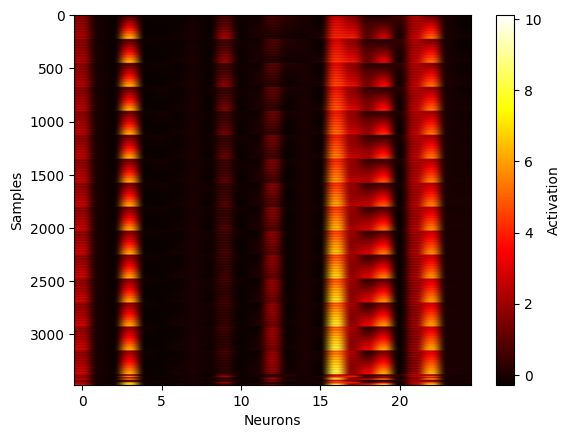

In [20]:
plt.imshow(hidden_tensor.numpy(), aspect='auto', cmap='hot')
plt.xlabel("Neurons")
plt.ylabel("Samples")
plt.colorbar(label="Activation")
plt.show()

here we can see that each row id one sample
and each column is one hidden neuron
and colour intensity shows how strogly that neuron/feature activated for that sample

-- Vertical bright strip shows the neuron that is fire for many samples.

-- Horizonatl brght if any shows the sample that active many neurosn

To gain better insight, we now visualize the same activations in a graphical form using a heatmap-style layout for each neuron seperately, where color intensity indicates the magnitude of neuron activations.


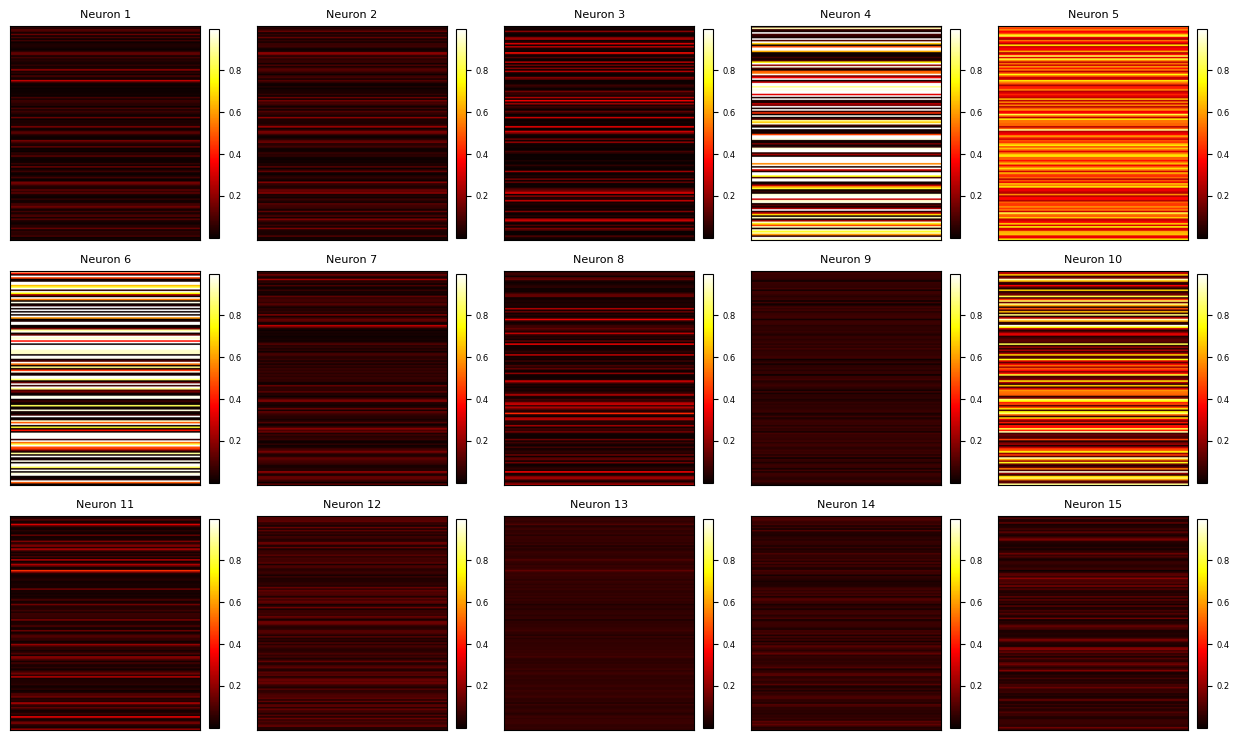

In [15]:
def plot_last_batch_activations(activations, num_neurons, neurons_per_row, save_path=None):
    """
    Visualizes neuron activations across samples in the last mini-batch.

    Each subplot represents one neuron. The vertical axis shows samples in the batch.
    Color intensity is the  activation magnitude. All subplots use the same color range
    for consistent interpretation.
    """

    activations = np.array(activations)
    num_rows = (num_neurons + neurons_per_row - 1) // neurons_per_row
    fig, axes = plt.subplots(num_rows, neurons_per_row, figsize=(neurons_per_row * 2.5, num_rows * 2.5))
    axes = axes.flatten()

    # Compute global min and max for consistent color intensity
    vmin, vmax = activations.min(), activations.max()

    for i in range(num_neurons):
        if i >= activations.shape[1]:
            break
        ax = axes[i]
        im = ax.imshow(activations[:, i].reshape(-1, 1),
                       aspect='auto', cmap='hot', vmin=vmin, vmax=vmax)
        ax.set_title(f'Neuron {i+1}', fontsize=8)
        ax.set_xticks([])
        ax.set_yticks([])

        # Individual colorbar
        cbar = plt.colorbar(im, ax=ax, fraction=0.05, pad=0.04)
        cbar.ax.tick_params(labelsize=6)

    # Hide unused subplots
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=600, bbox_inches='tight')
    plt.show()


# Example call
plot_last_batch_activations(last_batch_encoded, num_neurons=15, neurons_per_row=5, save_path="last_batch_activations.png")
